In [1]:
library(dplyr)
library(tidyr)
library(readr)
library(GenomicRanges)
library(reshape2)
library(openxlsx)
library(ggplot2)
library(Matrix)
library(EpiTrace)
library(Seurat)
library(SeuratObject)
library(ggtree)
#library(EnsDb.Hsapiens.v86)
library(patchwork)
library(ArchR)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, whic

In [2]:
setwd('/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/epitrace') 
datadir = '/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/epitrace' 

In [3]:
addArchRThreads(threads = 32)
addArchRGenome("mm10")

Setting default number of Parallel threads to 32.

Setting default genome to Mm10.



In [4]:
inputFiles <- list.files(path='/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scATAC_and_scRNA/outs/',pattern = 'fragments.tsv.gz$',full.names = T,recursive = T)
inputFiles <- as.list(inputFiles)
names_of_inputfiles <- gsub('_.+','',gsub('.+/','',gsub('/outs.+','',unlist(inputFiles))))
names(inputFiles) <- names_of_inputfiles


In [5]:
ArrowFiles <- createArrowFiles(
  inputFiles = as.character(as.vector(inputFiles)),
  sampleNames = names(inputFiles),
  filterTSS = 4,
  filterFrags = 1000,
  addTileMat = TRUE,
  addGeneScoreMat = TRUE
)

doubScores <- addDoubletScores(
  input = ArrowFiles,
  k = 10,
  knnMethod = "UMAP",
  LSIMethod = 1
)

proj_arrow <- ArchRProject(
  ArrowFiles = ArrowFiles,
  outputDirectory = "scATAC_etracer",
  copyArrows = TRUE
)

proj_arrow <- filterDoublets(proj_arrow)

dir.create('Save')
saveArchRProject(ArchRProj = proj_arrow, outputDirectory = "Save/etracer.ArchR.Object", load = T) -> proj_arrow

filterFrags is no longer a valid input. Please use minFrags! Setting filterFrags value to minFrags!

filterTSS is no longer a valid input. Please use minTSS! Setting filterTSS value to minTSS!

Using GeneAnnotation set by addArchRGenome(Mm10)!

Using GeneAnnotation set by addArchRGenome(Mm10)!

ArchR logging to : ArchRLogs/ArchR-createArrows-26f942acbb1b-Date-2025-07-09_Time-19-14-36.515579.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

subThreading Disabled since ArchRLocking is TRUE see `addArchRLocking`

2025-07-09 19:14:36.877329 : Batch Execution w/ safelapply!, 0 mins elapsed.

(scATAC : 1 of 1) Determining Arrow Method to use!

2025-07-09 19:14:36.958341 : (scATAC : 1 of 1) Reading In Fragments from inputFiles (readMethod = tabix), 0.001 mins elapsed.

2025-07-09 19:14:36.971474 : (scATAC : 1 of 1) Tabix Bed To Temporary File, 0.002 mins elapsed.

Warning message in sprintf("%s Reading TabixFile %s Percent", prefix, round(100 * :
“one 

In [6]:
# LSI
proj_arrow <- addIterativeLSI( ArchRProj = proj_arrow,useMatrix = "TileMatrix", name = "IterativeLSI", iterations = 2,clusterParams = list( resolution = c(0.2), sampleCells = NULL, n.start = 10), varFeatures = 25000, dimsToUse = 2:30,force = TRUE)
# Add cluster based on LSI
proj_arrow <- addClusters(input = proj_arrow,reducedDims = "IterativeLSI",method = "Seurat",name = "seurat_clusters",resolution = 0.3,force = TRUE)
proj_arrow <- addGeneScoreMatrix(input = proj_arrow,force = TRUE)
# Add embeding
proj_arrow <- addUMAP(ArchRProj = proj_arrow, reducedDims = "IterativeLSI", name = "UMAP", nNeighbors = 30, minDist = 0.5,metric = "cosine",force = TRUE)

# Add grouped coverage
proj_arrow <- addGroupCoverages(ArchRProj = proj_arrow, groupBy = "seurat_clusters",force = T)
# Add imputation for visualization
proj_arrow <- addImputeWeights(proj_arrow)
# Add peaks
proj_arrow <- addReproduciblePeakSet(
  ArchRProj = proj_arrow,
  groupBy = "seurat_clusters",force = T,
  pathToMacs2 = '/home/liangzhen/anaconda3/envs/scenicplus/bin/macs2' # change this to your MACS2 address
)
proj_arrow <- addPeakMatrix(proj_arrow,force = T)
proj_arrow <- addBgdPeaks(proj_arrow,force = T)
proj_arrow <- saveArchRProject(ArchRProj = proj_arrow,load = T)

getMatrixFromProject(proj_arrow,useMatrix = 'PeakMatrix') -> mtx
getPeakSet(proj_arrow) -> GR
save(list=c('GR','mtx'),file='proj_arrow_export.Rdata')

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-26f947c64ce4d-Date-2025-07-09_Time-20-27-55.690299.log
If there is an issue, please report to github with logFile!

2025-07-09 20:27:57.284424 : Computing Total Across All Features, 0.009 mins elapsed.

2025-07-09 20:27:58.83975 : Computing Top Features, 0.035 mins elapsed.

###########
2025-07-09 20:28:02.471958 : Running LSI (1 of 2) on Top Features, 0.096 mins elapsed.
###########

2025-07-09 20:28:02.491557 : Creating Partial Matrix, 0.096 mins elapsed.

2025-07-09 20:28:40.876261 : Computing LSI, 0.736 mins elapsed.

2025-07-09 20:29:31.32916 : Identifying Clusters, 1.577 mins elapsed.

2025-07-09 20:29:33.489903 : Identified 3 Clusters, 1.613 mins elapsed.

2025-07-09 20:29:33.502289 : Saving LSI Iteration, 1.613 mins elapsed.

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from names

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2011
Number of edges: 77623

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8336
Number of communities: 4
Elapsed time: 0 seconds


2025-07-09 20:31:57.004617 : Testing Outlier Clusters, 0.035 mins elapsed.

2025-07-09 20:31:57.011801 : Assigning Cluster Names to 4 Clusters, 0.036 mins elapsed.

2025-07-09 20:31:57.107668 : Finished addClusters, 0.037 mins elapsed.

ArchR logging to : ArchRLogs/ArchR-addGeneScoreMatrix-26f94401f9f2e-Date-2025-07-09_Time-20-31-57.12143.log
If there is an issue, please report to github with logFile!

subThreading Disabled since ArchRLocking is TRUE see `addArchRLocking`

2025-07-09 20:31:57.54783 : Batch Execution w/ safelapply!, 0 mins elapsed.

.createArrowGroup : Arrow Group already exists! Dropping Group from ArrowFile! This will take ~10-30 seconds!

.dropGroupsFromArrow : Initializing Temp ArrowFile

.dropGroupsFromArrow : Adding Metadata to Temp ArrowFile

.dropGroupsFromArrow : Adding SubGroups to Temp ArrowFile

.dropGroupsFromArrow : Move Temp ArrowFile to ArrowFile

scATAC .addGeneScoreMat useTSS = FALSE

2025-07-09 20:32:36.047611 : Computing Gene Scores using distance re

   Group nCells nCellsUsed nReplicates nMin nMax maxPeaks
C1    C1    337        337           2   40  297   150000
C2    C2    673        540           2   40  500   150000
C3    C3    683        540           2   40  500   150000
C4    C4    318        318           2   40  278   150000


2025-07-09 20:53:45.991516 : Batching Peak Calls!, 0.01 mins elapsed.

2025-07-09 20:53:46.009511 : Batch Execution w/ safelapply!, 0 mins elapsed.

2025-07-09 20:59:35.830541 : Identifying Reproducible Peaks!, 5.84 mins elapsed.

2025-07-09 20:59:47.596519 : Creating Union Peak Set!, 6.036 mins elapsed.

Converged after 5 iterations!

Plotting Ggplot!

2025-07-09 20:59:55.997622 : Finished Creating Union Peak Set (122266)!, 6.176 mins elapsed.

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-26f9457b5bc66-Date-2025-07-09_Time-20-59-56.007406.log
If there is an issue, please report to github with logFile!

2025-07-09 20:59:56.772936 : Batch Execution w/ safelapply!, 0 mins elapsed.

2025-07-09 20:59:59.63154 : Adding scATAC to PeakMatrix for Chr (1 of 20)!, 0.007 mins elapsed.

2025-07-09 21:00:12.249155 : Adding scATAC to PeakMatrix for Chr (2 of 20)!, 0.217 mins elapsed.

2025-07-09 21:00:25.197479 : Adding scATAC to PeakMatrix for Chr (3 of 20)!, 0.433 mins elapsed.

2025-07-09 21:

In [7]:
#mouse_clock_by_human <- readRDS('mouse_clock_lifted_human_to_mouse_mm10.rds')
mouse_clock_by_MM285 <- readRDS('mouse_clock_mm285_design_clock347_mm10.rds')

In [101]:
initiated_peaks <- Init_Peakset(GR)
initiated_peaks_df <- as.data.frame(initiated_peaks,row.names = NULL)

rownames(mtx@colData) -> cellname_vec
paste0(initiated_peaks_df$seqnames,'_',initiated_peaks_df$start,'_',initiated_peaks_df$end) -> initiated_peaks_df$peakName

as(assays(mtx)[['PeakMatrix']], "sparseMatrix") -> mtx2
initiated_mm <- Init_Matrix(cellname = cellname_vec,peakname = initiated_peaks_df$peakName,matrix = mtx2)

EpiTraceAge_Convergence(peakSet = initiated_peaks,matrix=initiated_mm,ref_genome='mm10',clock_gr=mouse_clock_by_MM285,iterative_time = 5,min.cutoff = 0,non_standard_clock = T,qualnum = 10,ncore_lim = 48,mean_error_limit = 0.1) -> epitrace_obj_age_estimated_mouse 
epitrace_obj_age_estimated_meta <- epitrace_obj_age_estimated_mouse@meta.data
#saveRDS(epitrace_obj_age_estimated_meta,file='epitrace_obj_age_estimated_meta.rds')

please make double sure your ref genome, peak set and cells are similar.

Preparing obj...

ref clock list is not standard. Please make sure the input data, peak set and clock set are in similar reference genome.

Input peakset is set to be hg19

Joining with `by = join_by(Clock_panel)`
add iterative

good quality cells 1796 and peaks 127

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Finished prepare obj

Estimating age for initialization...

Finished age estimation

Iterating 1

Performing Corr 

Finished Corr 

Calculate iterative age

Parallel run

Update dataframe

Joining with `by = join_by(cell)`
mean_error = 0.20293620549567

Iterating 2

Performing Corr 

Finished Corr 

Calculate iterative age

Parallel run

Update dataframe

Joining with `by = join_by(cell)`
mean_error = 0.113116320916161

Iterating 3

Performing Corr 

Finished Corr 

Cal

In [15]:
epitrace_obj_age_estimated_meta <- readRDS('epitrace_obj_age_estimated_meta.rds')

In [16]:
predictions <- read.table('/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/multiome_RNA_metadata.csv',sep=',',header=T,row.names = 1)
predictions

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.8,seurat_clusters,RNA_snn_res.0.3,RNA_snn_res.0.4,RNA_snn_res.0.6,predicted.id,prediction.score.2,prediction.score.1,prediction.score.3,prediction.score.4,prediction.score.5,prediction.score.max,umap_1,umap_2
,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAACAGCCAGGCCATT-1,SeuratProject,59544,7436,13.786444,4,1,1,0,4,2,1.000000000,0.000000000,0.000000000,0.000000000,0.0000000,1.0000000,-5.9393898,0.6195063
AAACATGCACCCTCAC-1,SeuratProject,11604,3725,10.617029,3,0,0,3,2,3,0.000000000,0.236366197,0.763633803,0.000000000,0.0000000,0.7636338,3.6502311,-0.8035753
AAACATGCAGGCTACT-1,SeuratProject,17107,4309,17.793886,3,0,0,3,2,3,0.004505803,0.130255489,0.584065686,0.000000000,0.2811730,0.5840657,1.3199842,-0.2236029
AAACCGCGTCTTGCTG-1,SeuratProject,17680,4029,19.049774,1,0,0,2,1,3,0.000000000,0.010647426,0.989352574,0.000000000,0.0000000,0.9893526,3.2400333,-0.8330461
AAACCGCGTGGTTCTT-1,SeuratProject,9952,2878,18.488746,2,1,1,0,3,2,1.000000000,0.000000000,0.000000000,0.000000000,0.0000000,1.0000000,-3.1798540,2.5502737
AAACCGGCAAGGACCA-1,SeuratProject,14508,3857,8.422939,2,1,1,0,3,2,1.000000000,0.000000000,0.000000000,0.000000000,0.0000000,1.0000000,-2.5180348,1.6121159
AAACCGGCACAAAGGT-1,SeuratProject,15842,3891,17.624037,0,0,0,2,1,3,0.000000000,0.000000000,1.000000000,0.000000000,0.0000000,1.0000000,3.8435633,1.6311522
AAACCGGCAGTGAACG-1,SeuratProject,10179,3167,15.404264,7,0,0,3,2,2,0.585503462,0.017201335,0.397295204,0.000000000,0.0000000,0.5855035,-1.8605426,2.1261519
AAACGGATCCAGGTTG-1,SeuratProject,4288,1633,8.115672,6,0,0,1,1,3,0.021438701,0.113518931,0.865042368,0.000000000,0.0000000,0.8650424,4.1253373,-3.3002197


In [17]:
epitrace_obj_age_estimated_meta$Sample <- gsub('scATAC#','',epitrace_obj_age_estimated_meta$cell)
epitrace_obj_age_estimated_meta

,orig.ident,nCount_peaks,nFeature_peaks,cell,nCount_iterative,nFeature_iterative,EpiTraceAge_iterative,Accessibility_iterative,AccessibilitySmooth_iterative,EpiTraceAge_Clock_initial,Accessibility_initial,AccessibilitySmooth_initial,Sample,state,lineageGrp
,<fct>,<dbl>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>
scATAC#AGGCTAGCAGGACCTT-1,SeuratProject,231,82,scATAC#AGGCTAGCAGGACCTT-1,231,82,0.8475196,2024,1.173112,0.9080780,82,0.7449539,AGGCTAGCAGGACCTT-1,2,C2
scATAC#CTAGGCGGTCAAGTGC-1,SeuratProject,155,60,scATAC#CTAGGCGGTCAAGTGC-1,155,60,0.5436031,1875,1.106444,0.4473538,60,0.5150288,CTAGGCGGTCAAGTGC-1,2,C1
scATAC#GAAGCCTGTACTGATG-1,SeuratProject,162,67,scATAC#GAAGCCTGTACTGATG-1,162,67,0.4140992,1868,1.099935,0.3192201,67,0.5423263,GAAGCCTGTACTGATG-1,3,C5
scATAC#GTCATGCCAGGCATGA-1,SeuratProject,181,72,scATAC#GTCATGCCAGGCATGA-1,181,72,0.6386423,1954,1.144883,0.9721448,72,0.5852929,GTCATGCCAGGCATGA-1,3,C3
scATAC#AACCTTGCATGGTTAT-1,SeuratProject,163,61,scATAC#AACCTTGCATGGTTAT-1,163,61,0.9989556,1903,1.123782,0.3944290,61,0.5376615,AACCTTGCATGGTTAT-1,3,C1
scATAC#TTGGTGAGTCATTACC-1,SeuratProject,171,61,scATAC#TTGGTGAGTCATTACC-1,171,61,0.8590078,1914,1.119854,0.8122563,61,0.5491150,TTGGTGAGTCATTACC-1,3,C1
scATAC#GTCATCACACCAACCG-1,SeuratProject,145,63,scATAC#GTCATCACACCAACCG-1,145,63,0.5300261,1844,1.102766,0.5309192,63,0.5042478,GTCATCACACCAACCG-1,1,C2
scATAC#GATTCCTGTAACGTGC-1,SeuratProject,176,62,scATAC#GATTCCTGTAACGTGC-1,176,62,0.8945170,1930,1.124179,0.9526462,62,0.5551431,GATTCCTGTAACGTGC-1,3,C1
scATAC#CGTAACCCATAAACCT-1,SeuratProject,146,58,scATAC#CGTAACCCATAAACCT-1,146,58,0.7879896,1897,1.151196,0.5264624,58,0.4844501,CGTAACCCATAAACCT-1,3,C3


In [18]:
epitrace_obj_age_estimated_meta$state <- predictions[epitrace_obj_age_estimated_meta$Sample,'predicted.id']
epitrace_obj_age_estimated_meta <- epitrace_obj_age_estimated_meta[!is.na(epitrace_obj_age_estimated_meta$state),]
epitrace_obj_age_estimated_meta$state <- as.character(epitrace_obj_age_estimated_meta$state)
epitrace_obj_age_estimated_meta <- epitrace_obj_age_estimated_meta[epitrace_obj_age_estimated_meta$state %in% c('1','2','3','5'),]
epitrace_obj_age_estimated_meta

,orig.ident,nCount_peaks,nFeature_peaks,cell,nCount_iterative,nFeature_iterative,EpiTraceAge_iterative,Accessibility_iterative,AccessibilitySmooth_iterative,EpiTraceAge_Clock_initial,Accessibility_initial,AccessibilitySmooth_initial,Sample,state,lineageGrp
,<fct>,<dbl>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>
scATAC#AGGCTAGCAGGACCTT-1,SeuratProject,231,82,scATAC#AGGCTAGCAGGACCTT-1,231,82,0.8475196,2024,1.173112,0.9080780,82,0.7449539,AGGCTAGCAGGACCTT-1,2,C2
scATAC#CTAGGCGGTCAAGTGC-1,SeuratProject,155,60,scATAC#CTAGGCGGTCAAGTGC-1,155,60,0.5436031,1875,1.106444,0.4473538,60,0.5150288,CTAGGCGGTCAAGTGC-1,2,C1
scATAC#GAAGCCTGTACTGATG-1,SeuratProject,162,67,scATAC#GAAGCCTGTACTGATG-1,162,67,0.4140992,1868,1.099935,0.3192201,67,0.5423263,GAAGCCTGTACTGATG-1,3,C5
scATAC#GTCATGCCAGGCATGA-1,SeuratProject,181,72,scATAC#GTCATGCCAGGCATGA-1,181,72,0.6386423,1954,1.144883,0.9721448,72,0.5852929,GTCATGCCAGGCATGA-1,3,C3
scATAC#AACCTTGCATGGTTAT-1,SeuratProject,163,61,scATAC#AACCTTGCATGGTTAT-1,163,61,0.9989556,1903,1.123782,0.3944290,61,0.5376615,AACCTTGCATGGTTAT-1,3,C1
scATAC#TTGGTGAGTCATTACC-1,SeuratProject,171,61,scATAC#TTGGTGAGTCATTACC-1,171,61,0.8590078,1914,1.119854,0.8122563,61,0.5491150,TTGGTGAGTCATTACC-1,3,C1
scATAC#GTCATCACACCAACCG-1,SeuratProject,145,63,scATAC#GTCATCACACCAACCG-1,145,63,0.5300261,1844,1.102766,0.5309192,63,0.5042478,GTCATCACACCAACCG-1,1,C2
scATAC#GATTCCTGTAACGTGC-1,SeuratProject,176,62,scATAC#GATTCCTGTAACGTGC-1,176,62,0.8945170,1930,1.124179,0.9526462,62,0.5551431,GATTCCTGTAACGTGC-1,3,C1
scATAC#CGTAACCCATAAACCT-1,SeuratProject,146,58,scATAC#CGTAACCCATAAACCT-1,146,58,0.7879896,1897,1.151196,0.5264624,58,0.4844501,CGTAACCCATAAACCT-1,3,C3


In [19]:
table(epitrace_obj_age_estimated_meta$state)


  1   2   3   5 
244 248 655  55 

In [20]:
epitrace_obj_age_estimated_meta

,orig.ident,nCount_peaks,nFeature_peaks,cell,nCount_iterative,nFeature_iterative,EpiTraceAge_iterative,Accessibility_iterative,AccessibilitySmooth_iterative,EpiTraceAge_Clock_initial,Accessibility_initial,AccessibilitySmooth_initial,Sample,state,lineageGrp
,<fct>,<dbl>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>
scATAC#AGGCTAGCAGGACCTT-1,SeuratProject,231,82,scATAC#AGGCTAGCAGGACCTT-1,231,82,0.8475196,2024,1.173112,0.9080780,82,0.7449539,AGGCTAGCAGGACCTT-1,2,C2
scATAC#CTAGGCGGTCAAGTGC-1,SeuratProject,155,60,scATAC#CTAGGCGGTCAAGTGC-1,155,60,0.5436031,1875,1.106444,0.4473538,60,0.5150288,CTAGGCGGTCAAGTGC-1,2,C1
scATAC#GAAGCCTGTACTGATG-1,SeuratProject,162,67,scATAC#GAAGCCTGTACTGATG-1,162,67,0.4140992,1868,1.099935,0.3192201,67,0.5423263,GAAGCCTGTACTGATG-1,3,C5
scATAC#GTCATGCCAGGCATGA-1,SeuratProject,181,72,scATAC#GTCATGCCAGGCATGA-1,181,72,0.6386423,1954,1.144883,0.9721448,72,0.5852929,GTCATGCCAGGCATGA-1,3,C3
scATAC#AACCTTGCATGGTTAT-1,SeuratProject,163,61,scATAC#AACCTTGCATGGTTAT-1,163,61,0.9989556,1903,1.123782,0.3944290,61,0.5376615,AACCTTGCATGGTTAT-1,3,C1
scATAC#TTGGTGAGTCATTACC-1,SeuratProject,171,61,scATAC#TTGGTGAGTCATTACC-1,171,61,0.8590078,1914,1.119854,0.8122563,61,0.5491150,TTGGTGAGTCATTACC-1,3,C1
scATAC#GTCATCACACCAACCG-1,SeuratProject,145,63,scATAC#GTCATCACACCAACCG-1,145,63,0.5300261,1844,1.102766,0.5309192,63,0.5042478,GTCATCACACCAACCG-1,1,C2
scATAC#GATTCCTGTAACGTGC-1,SeuratProject,176,62,scATAC#GATTCCTGTAACGTGC-1,176,62,0.8945170,1930,1.124179,0.9526462,62,0.5551431,GATTCCTGTAACGTGC-1,3,C1
scATAC#CGTAACCCATAAACCT-1,SeuratProject,146,58,scATAC#CGTAACCCATAAACCT-1,146,58,0.7879896,1897,1.151196,0.5264624,58,0.4844501,CGTAACCCATAAACCT-1,3,C3


png 
  2

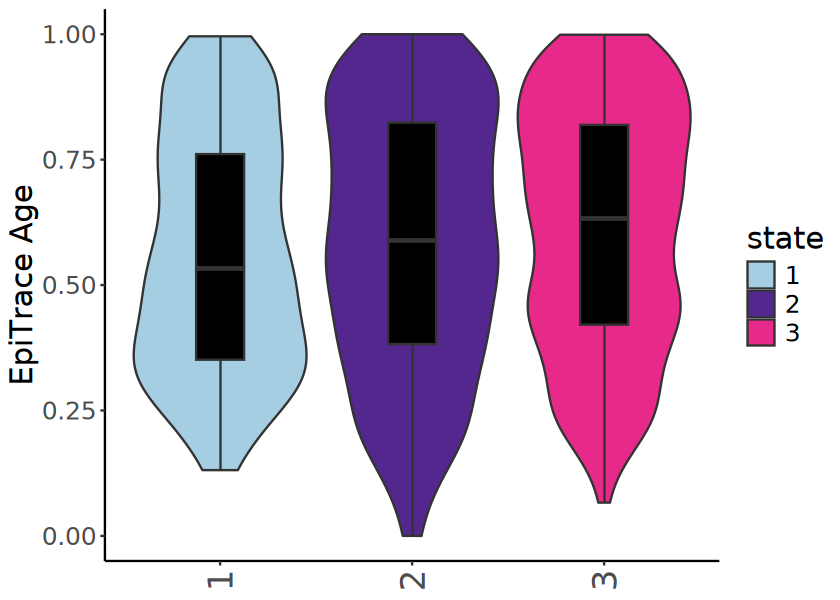

In [78]:
pdf('/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/epitrace/EpiTraceAge.pdf',width=7,height=6)
options(repr.plot.width=7, repr.plot.height=5)
plot <- ggplot(epitrace_obj_age_estimated_meta[epitrace_obj_age_estimated_meta$state %in% c('1','2','3'),],aes(x=state,y=EpiTraceAge_iterative)) + geom_violin(scale='width',aes(fill=state)) + geom_boxplot(width=0.25,fill='black',outlier.alpha = 0)  + theme_classic()  + theme(axis.text.x = element_text(angle=90,hjust=1,vjust=0.5,size=20),text=element_text(size=18),axis.title.x=element_blank()) + ylab('EpiTrace Age')+
scale_fill_manual(values = c('#a6cee3','#54278f','#e7298a','#ff6600'))
print(plot)
dev.off()
print(plot)